# Introduction

Every year teams in NHL pour countless resources into their scouting departments so that they can get an edge in that year’s draft by scouting for the best upcoming prospects who will be eligible for the draft. Which teams are the best at converting their draft picks to long-term skilled players, which positions are certain teams better at drafting, which amateur teams produce the best draft prospects? There are many questions that can be asked about how teams have performed historically in the draft, and this analysis could be useful for teams moving forward as they focus their efforts on drafting for specific positions, they may have historically had difficulty with or drafting a more well-rounded group of prospects. 

Some potential questions:

- What Amateur teams produce the best draft prospects
- What teams are best overall in the draft
- How much does the pick number indicate the long term success of players
- which positions are certain teams better at drafting
- etc.

# Data Description

The main data source we used for this project can be found [here](https://www.hockey-reference.com/draft/). This data set includes the following features: 

    - year: Year of draft
    - overall_pick: Overall pick player was drafted
    - team: Team player drafted to
    - player: Player drafted
    - nationality: Nationality of player drafted
    - position: Player position
    - age: Player age
    - to_year: Year draft pick played to
    - amateur_team: Amateur team drafted from
    - games_played: Total games played by player (non-goalie)
    - goals: Total goals
    - assists: Total assists
    - points: Total points
    - plus_minus: Plus minus of player
    - penalties_minutes: Penalties in minutes
    - goalie_games_played: Goalie games played
    - goalie_wins
    - goalie_losses
    - goalie_ties_overtime: Ties plus overtime/shootout losses
    - save_percentage
    - goals_against_average
    - point_shares

Additionally, we needed some way to rate a player's performance in the league. Although this is doable from from the statistics above, we decided another source of ratings would be needed as the stats above were not consistent with other sources of ratings.
We attempted to find ratings from EA Sports, but they only post their ratings for the top 50 players.
We then found a website with these ratings, but this website didn't allow scraping without creating a virtual web driver.
Thus, we landed on a csv file that can be found [here](https://github.com/ashleyjones-projects/NHL-Player-rating/blob/master/2019_ratings_3-year_avg.csv).

We used from the past 20 drafts to conduct the analysis. The features of importance were be the overall-pick, team, player, position, and age, as well as rating. Overall-pick might seem odd as it only available for a player after you draft them; however, we made the assumption that most players will be picked near their estimated pick, and so this can be used in the place of overall-pick if the model were to be used proactively.

## Pipeline Overview:
Drafts are split by years, so the first step is to get the data for a certain year. This is done with:
* `retrieve_data(year)`

This will return the dataframe of draft data for the given year.

The second step is to form the dictionary mapping a year to the dataframe of draft data for that year. This is done with:
* `draft_data_to_csvs(start, end)`

This will return a dictionary with years from start to end (assuming none failed) mapping to the draft data for that year. It will also store those dataframes in separate csvs so that it does not need to be called again should the data need to be reset.

Then, cleaning is performed, as discussed below.

Finally, the ratings are added in.

Sadly, we could not find ratings for goalies, so our modeling at the end 

In [4]:
#Use below if ratelimit not installed
#!pip install ratelimit

In [3]:
import pandas as pd
import requests
import numpy as np
import warnings
from ratelimit import limits, sleep_and_retry
warnings.simplefilter(action='ignore', category=(DeprecationWarning, FutureWarning))
# ignore warnings of type SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab as py
import seaborn as sns

In [4]:
@limits(calls=20, period=60)
@sleep_and_retry
def retrieve_data(year):
  """
  Returns the dataframe of data for the given year.

  Args:
    year (int): the year to retrieve draft data for

  Returns:
    (DataFrame): draft data
  """
  url = f'https://www.hockey-reference.com/draft/NHL_{year}_entry.html'
  response = requests.get(url)
  df = pd.read_html(response.text)[0]
  combined_column = df.apply(lambda row: row[('NHL Scoring Stats', 'GP')] if not pd.isnull(row[('NHL Scoring Stats', 'GP')]) else row[('NHL Goalie Stats', 'GP')], axis=1)
  df[('Something', 'GP')] = combined_column
  df.drop(columns=[('NHL Scoring Stats', 'GP'), ('NHL Goalie Stats', 'GP')], inplace=True)
  new_column_names = [col[1] if isinstance(col, tuple) else col for col in df.columns]
  df.set_axis(new_column_names, axis=1)
  df.columns = df.columns.droplevel(0)

  # Reset the index
  df.reset_index(inplace=True)
  df = df[df['Overall'] != 'Overall']
  df['Round'] = 0
  df.drop(columns=['index'], inplace=True)
  round = 1
  for index, row in df.iterrows():
    if pd.isna(row['Overall']):
      round += 1
    else:
      df.loc[index, 'Round'] = round
  df.dropna(subset=['Overall'], inplace=True)
  return df

In [5]:
def draft_data_to_csvs(start, end):
  """
  Writes a csv file for each year from start to end, inclusive.
  Returns the dictionary of year -> dataframe of data for the year.

  Args:
    start (int): first year to get data for
    end (int): last year to get data for
  Returns:
    (Dictionary): mapping of year to draft dataframe
  """

  draft_dict = {}
  for i in range(start, end + 1):
    print(i)
    try:
      draft_dict[i] = retrieve_data(i)
    except:
      print(f"Failed for year {i}")

  return draft_dict

In [6]:
df_dict1 = draft_data_to_csvs(1995, 2010)

1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


In [7]:
#wait like 5 minutes before running this if you want the full dataset. Otherwise, it will go up to around 2015 (if there were not other requests to the site previously)
df_dict2 = draft_data_to_csvs(2011, 2019)

2011
2012
2013
2014
2015
2016
2017
2018
2019


In [8]:
df_dict = df_dict1 | df_dict2

## Cleaning:

For the data cleaning, the data was split between goalie data and regular skater's data. This was done because analysis of goalies can't be done using the same metrics as analysis for skaters. All players who are still playing were removed from the data by using the 'To' column and searching for any players whose value was 2024. When adding the data frames together a new feature 'year' is added so that the draft years can be kept track off. In the respective skater and goalie data frames all the extraneous features were dropped. Additionally if a player had a null value in any of the numeric features that might be used for analysis they were dropped from the data.

In [9]:
overall_data_frame_skater = pd.DataFrame()
overall_data_frame_goalie = pd.DataFrame()
for key, value in df_dict.items():
    #remove players who are still playing
    data_frame = value
    data_frame = data_frame[data_frame['To'] != 2024]
    data_frame.dropna(subset=['G', 'A', 'PTS', '+/-', 'PIM', 'PS', 'GP', 'Round'], how='any', axis=0, inplace=True)
    data_frame['Round'] = data_frame['Round'].astype(int)
    data_frame['Overall'] = data_frame['Overall'].astype(int)
    data_frame['Age'] = data_frame['Age'].astype(int)
    data_frame['GP'] = data_frame['GP'].astype(float)
    data_frame['G'] = data_frame['G'].astype(float)
    data_frame['A'] = data_frame['A'].astype(float)
    data_frame['PTS'] = data_frame['PTS'].astype(float)
    data_frame['+/-'] = data_frame['+/-'].astype(float)
    data_frame['PIM'] = data_frame['PIM'].astype(float)
    data_frame['PS'] = data_frame['PS'].astype(float)
    data_frame['Year'] = key
    #split up the data frames:
    data_frame_goalie = data_frame[(data_frame['Pos'] == 'G')]
    data_frame_skater = data_frame[(data_frame['Pos'] != 'G')]
    data_frame_skater.drop(['W', 'L', 'T/O', 'SV%', 'GAA'], axis=1, inplace=True)
    data_frame_goalie.dropna(subset=['W', 'L', 'T/O', 'SV%', 'GAA'], how='any', axis=0, inplace=True)
    data_frame_goalie['GAA'] = data_frame_goalie['GAA'].astype(float)
    data_frame_goalie['SV%'] = data_frame_goalie['SV%'].astype(float)
    data_frame_goalie['W'] = data_frame_goalie['W'].astype(float)
    data_frame_goalie['L'] = data_frame_goalie['L'].astype(float)
    data_frame_goalie['T/O'] = data_frame_goalie['T/O'].astype(float)



    overall_data_frame_skater = pd.concat([overall_data_frame_skater, data_frame_skater])
    overall_data_frame_goalie = pd.concat([overall_data_frame_goalie, data_frame_goalie])

## Merge Sources:

In [10]:
#import the ratings data
df_ratings = pd.read_csv('2019_ratings_3-year_avg.csv')

In [11]:
df_ratings['Player'] = df_ratings['First_name'] + ' ' + df_ratings['Last_name']
df_ratings['Rating'] = df_ratings['Rating'] * 100
df_ratings.drop(['First_name', 'Last_name', 'Nation', 'Team'], axis=1, inplace=True)
merged_df = pd.merge(df_ratings, overall_data_frame_skater, on='Player', how='inner')
merged_df = merged_df.sample(frac=1)

#### Final Dataframe:

In [12]:
merged_df.head()

,Position,Rating,Player,Overall,Team,Nat.,Pos,Age,To,Amateur Team,G,A,PTS,+/-,PIM,PS,GP,Round,Year
290,C,79.848805,Sam Gagner,6,Edmonton Oilers,CA,C,18,2024,London Knights (OHL),195.0,328.0,523.0,-137.0,442.0,45.3,1024.0,1,2007
375,RW,77.935118,Conor Garland,123,Arizona Coyotes,US,RW,19,2024,Moncton Wildcats (QMJHL),85.0,116.0,201.0,17.0,133.0,20.9,345.0,5,2015
601,D,72.937666,Nick Schultz,33,Minnesota Wild,CA,D,18,2017,Prince Albert Raiders (WHL),30.0,145.0,175.0,-18.0,483.0,48.2,1069.0,2,2000
168,LW,83.825122,Tyler Bertuzzi,58,Detroit Red Wings,CA,LW,18,2024,Guelph Storm (OHL),97.0,130.0,227.0,-35.0,209.0,21.5,346.0,2,2013
33,C,90.255331,Nicklas Backstrom,4,Washington Capitals,SE,C,18,2024,Brynas IF (Sweden),271.0,762.0,1033.0,83.0,504.0,104.9,1105.0,1,2006


# Visual Analysis

# Number of Players from each Amateur Team:

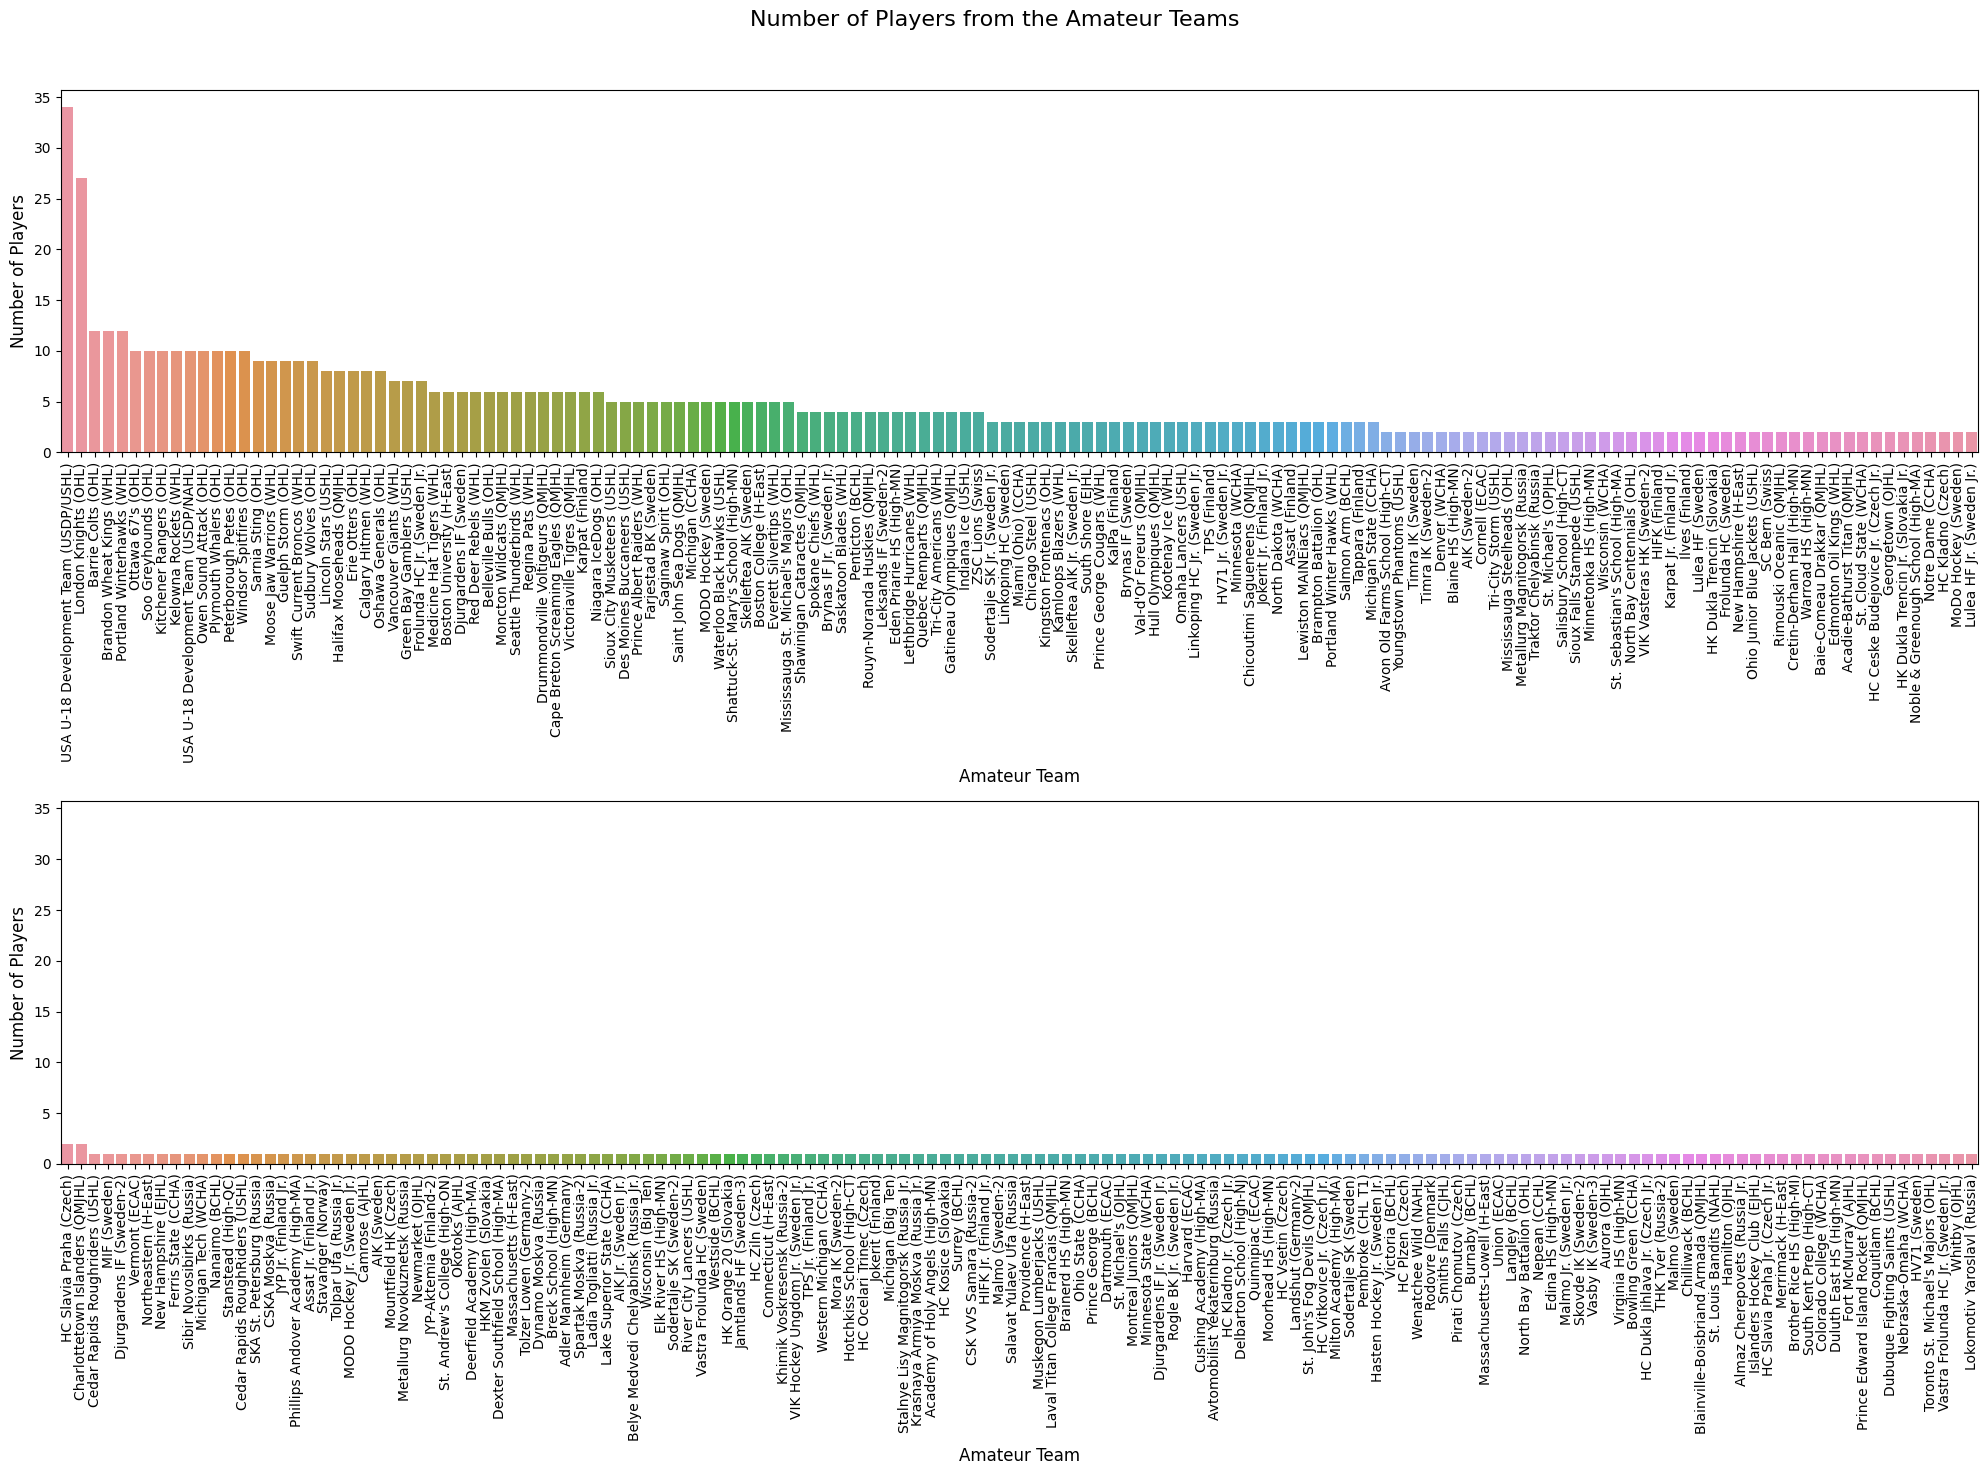

In [43]:
# comparing the number of players from the different teams to see which team has the most players coming from them

# Assuming 'Amateur Team' is the column containing team names in your DataFrame
team_counts = merged_df['Amateur Team'].value_counts()

# Splitting into two subplots
fig, axes = plt.subplots(nrows=2, figsize=(20, 15), sharey=True)
fig.suptitle('Number of Players from the Amateur Teams', fontsize=16)

# Plotting the first half of teams
sns.countplot(x='Amateur Team', data=merged_df, order=team_counts.index[:len(team_counts)//2], ax=axes[0])
axes[0].set_xlabel('Amateur Team', fontsize=12)
axes[0].set_ylabel('Number of Players', fontsize=12)
axes[0].tick_params(axis='x', rotation=90, labelsize=10)

# Plotting the second half of teams
sns.countplot(x='Amateur Team', data=merged_df, order=team_counts.index[len(team_counts)//2:], ax=axes[1])
axes[1].set_xlabel('Amateur Team', fontsize=12)
axes[1].set_ylabel('Number of Players', fontsize=12)
axes[1].tick_params(axis='x', rotation=90, labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout for title
plt.show()



# Rating By Amateur Team:

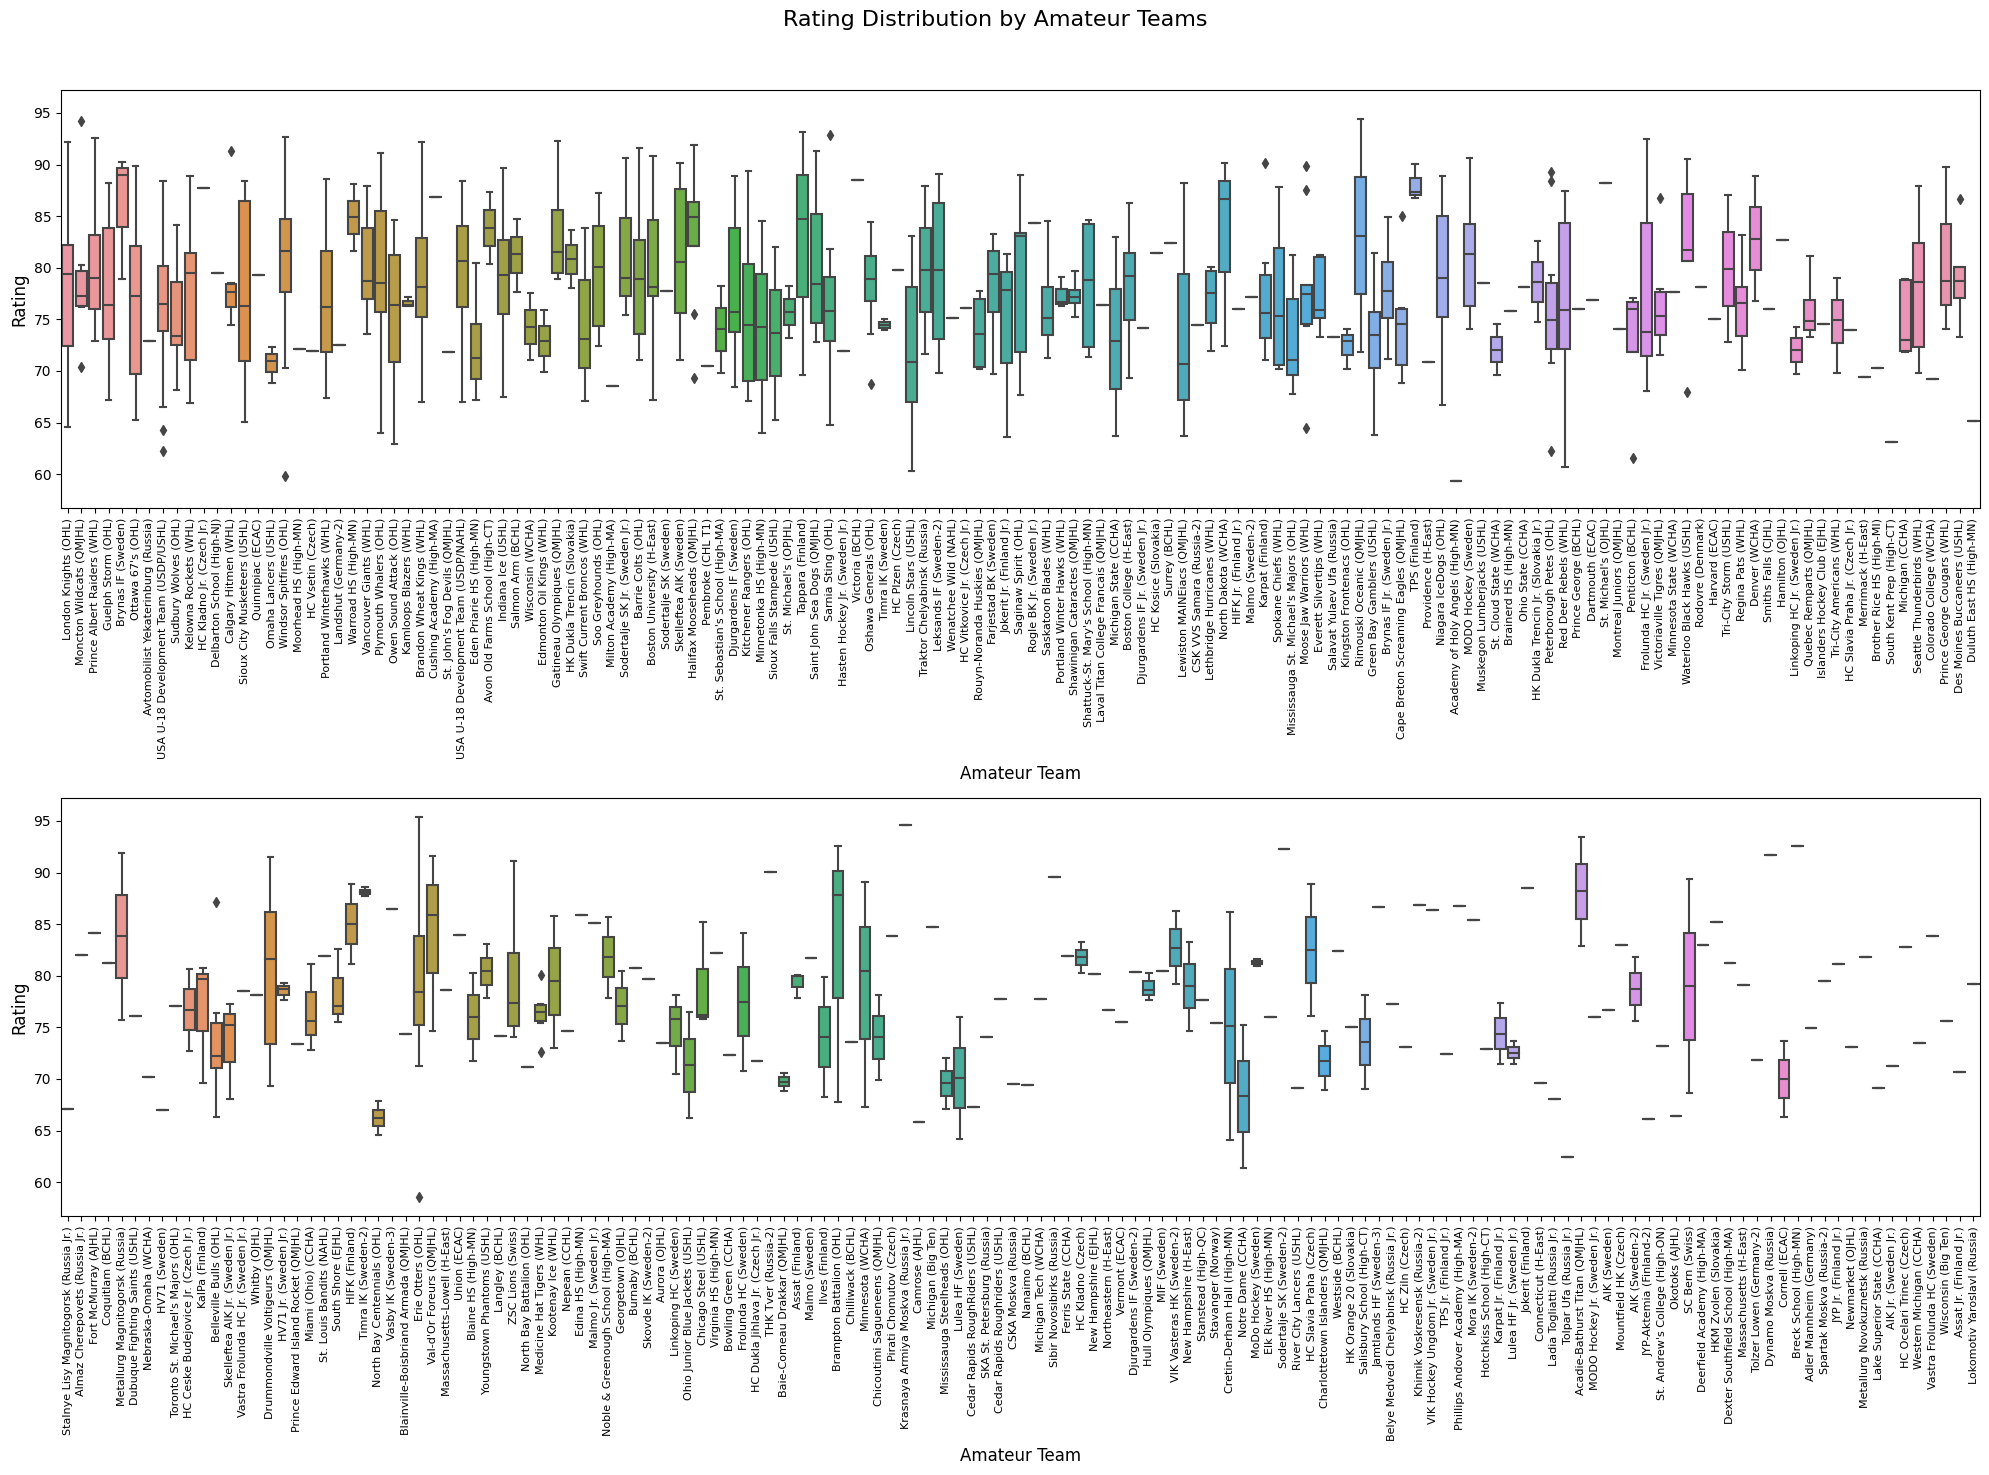

In [44]:
team_order = merged_df['Amateur Team'].unique()  # Get unique teams in original order

# Splitting into two subplots
fig, axes = plt.subplots(nrows=2, figsize=(20, 15), sharey=True)
fig.suptitle('Rating Distribution by Amateur Teams', fontsize=16)

# Plotting the first half of teams
sns.boxplot(data=merged_df[merged_df['Amateur Team'].isin(team_order[:len(team_order)//2])],
            x='Amateur Team', y='Rating', ax=axes[0])
axes[0].set_xlabel('Amateur Team', fontsize=12)
axes[0].set_ylabel('Rating', fontsize=12)
axes[0].tick_params(axis='x', rotation=90, labelsize=8)

# Plotting the second half of teams
sns.boxplot(data=merged_df[merged_df['Amateur Team'].isin(team_order[len(team_order)//2:])],
            x='Amateur Team', y='Rating', ax=axes[1])
axes[1].set_xlabel('Amateur Team', fontsize=12)
axes[1].set_ylabel('Rating', fontsize=12)
axes[1].tick_params(axis='x', rotation=90, labelsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout for title
plt.show()

# Specifically for goalies:

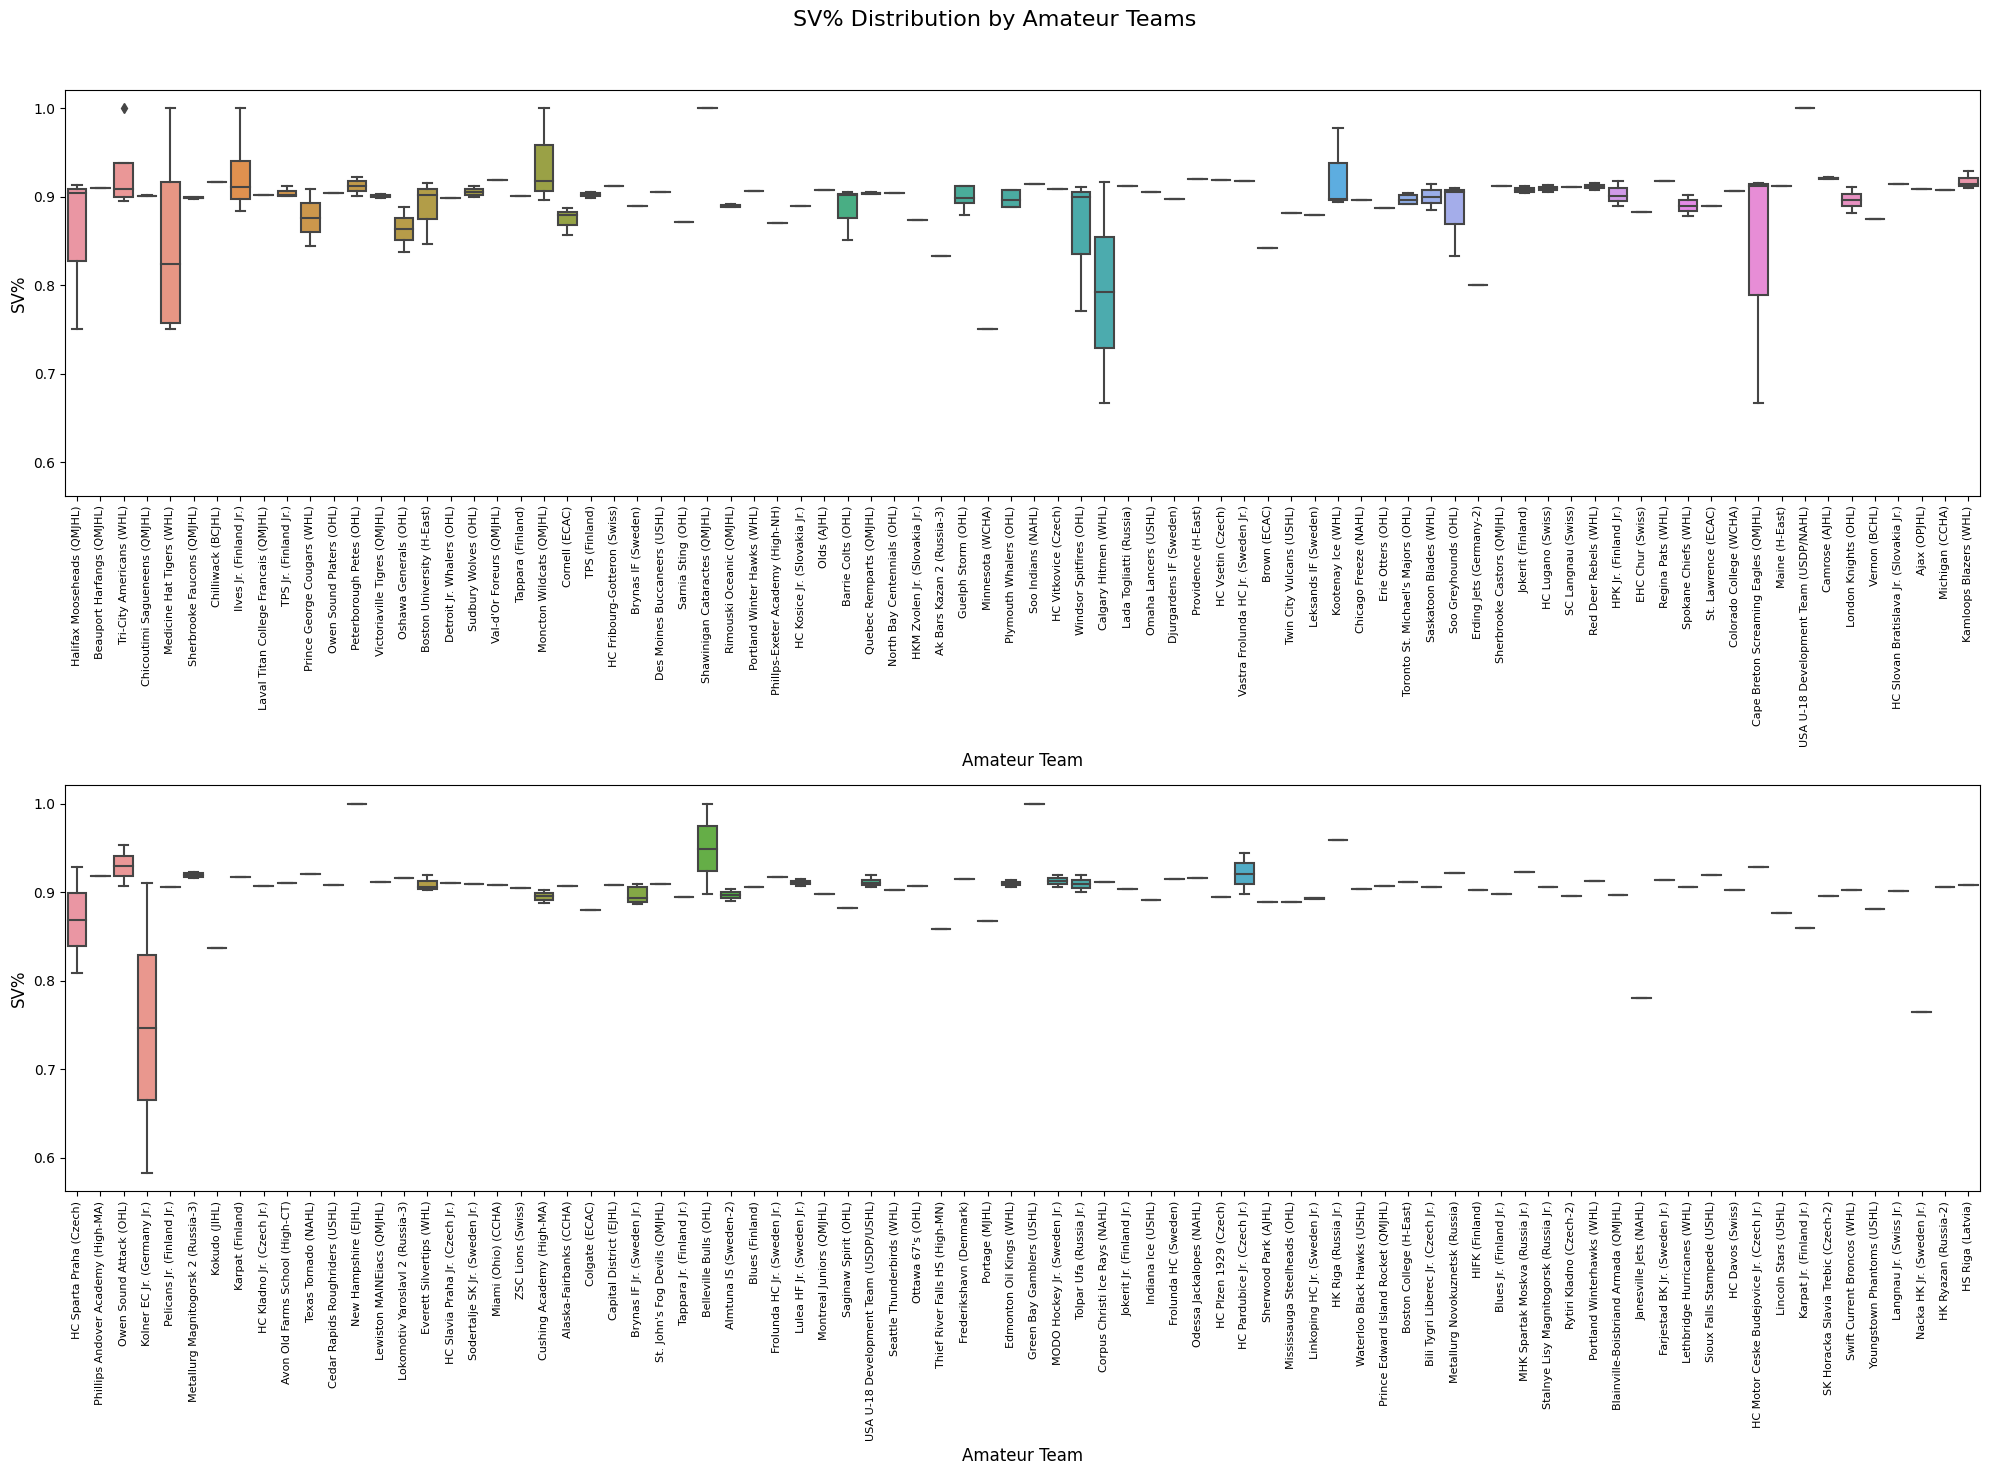

In [45]:
team_order = overall_data_frame_goalie['Amateur Team'].unique()  # Get unique teams in original order

# Splitting into two subplots
fig, axes = plt.subplots(nrows=2, figsize=(20, 15), sharey=True)
fig.suptitle('SV% Distribution by Amateur Teams', fontsize=16)

# Plotting the first half of teams
sns.boxplot(data=overall_data_frame_goalie[overall_data_frame_goalie['Amateur Team'].isin(team_order[:len(team_order)//2])],
            x='Amateur Team', y='SV%', ax=axes[0])
axes[0].set_xlabel('Amateur Team', fontsize=12)
axes[0].set_ylabel('SV%', fontsize=12)
axes[0].tick_params(axis='x', rotation=90, labelsize=8)

# Plotting the second half of teams
sns.boxplot(data=overall_data_frame_goalie[overall_data_frame_goalie['Amateur Team'].isin(team_order[len(team_order)//2:])],
            x='Amateur Team', y='SV%', ax=axes[1])
axes[1].set_xlabel('Amateur Team', fontsize=12)
axes[1].set_ylabel('SV%', fontsize=12)
axes[1].tick_params(axis='x', rotation=90, labelsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout for title
plt.show()

## Scatterplots:

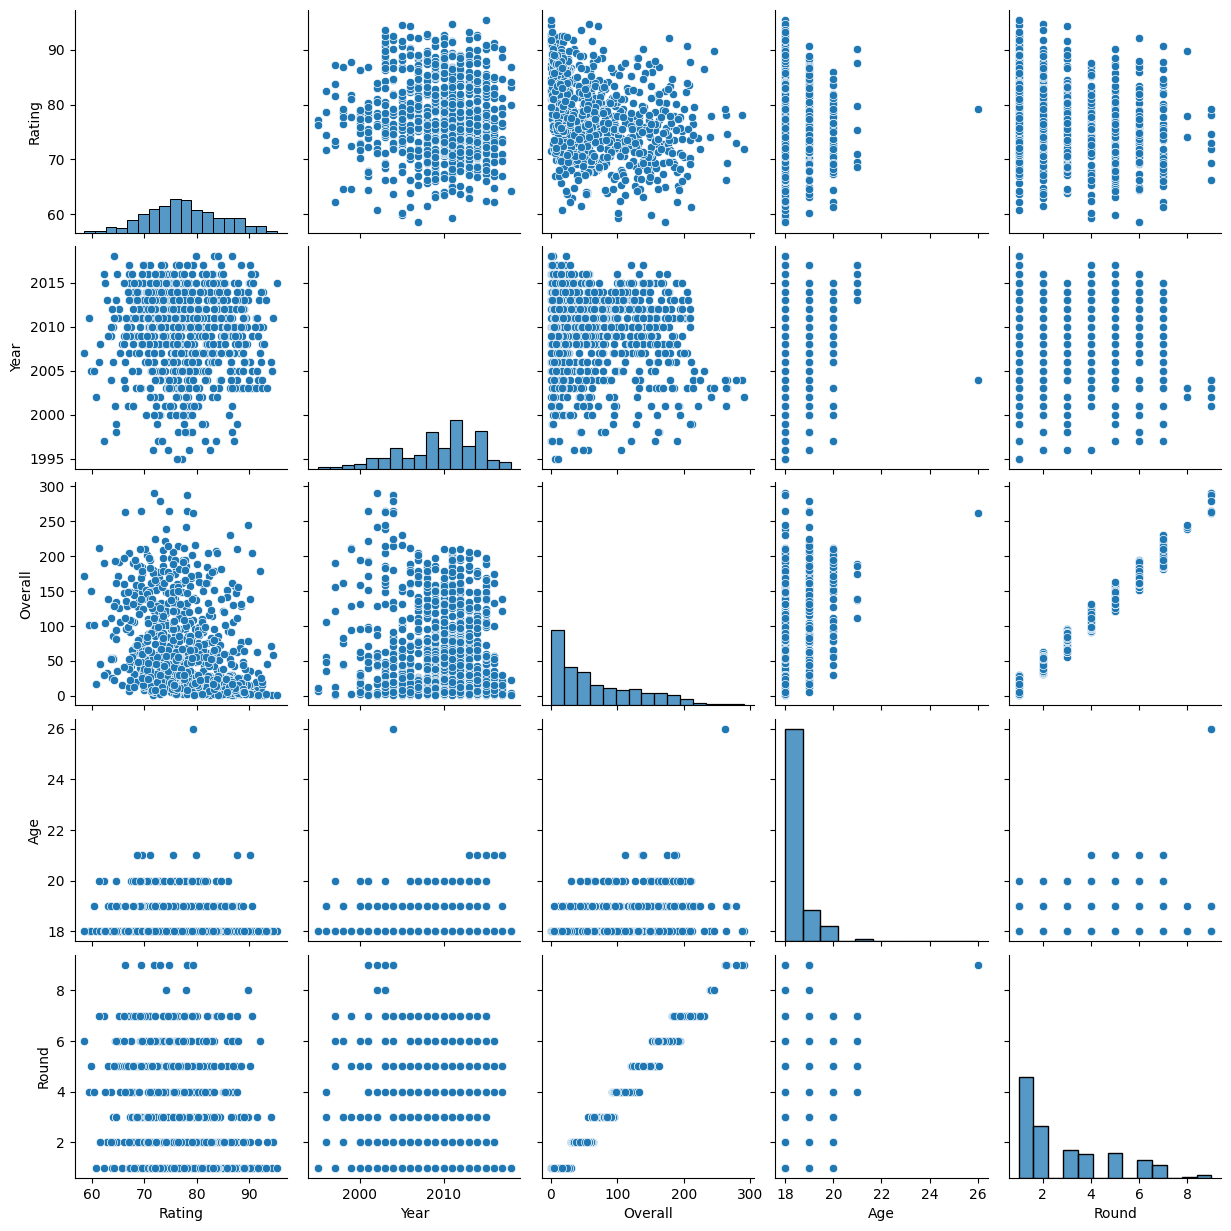

In [13]:
sns.pairplot(merged_df[['Rating', 'Year', 'Overall', 'Age', 'Round']])

<Axes: xlabel='Overall', ylabel='Rating'>

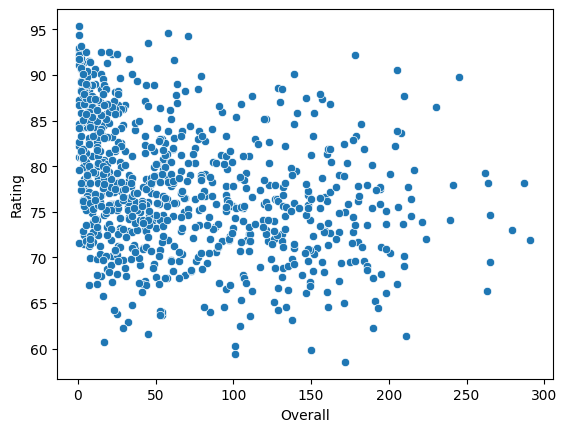

In [14]:
sns.scatterplot(x='Overall', y='Rating', data=merged_df)

<Axes: xlabel='Round', ylabel='Rating'>

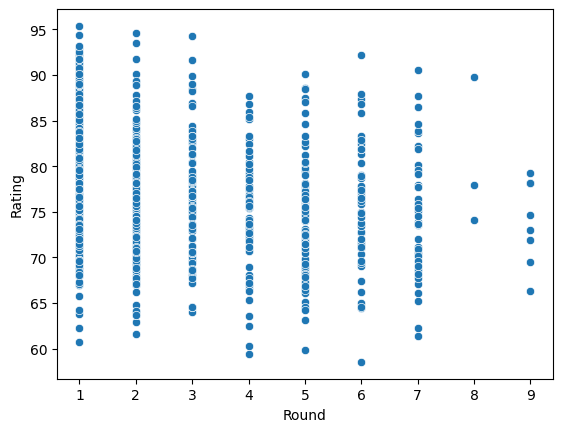

In [15]:
sns.scatterplot(x='Round', y='Rating', data=merged_df)

<Axes: xlabel='Age', ylabel='Rating'>

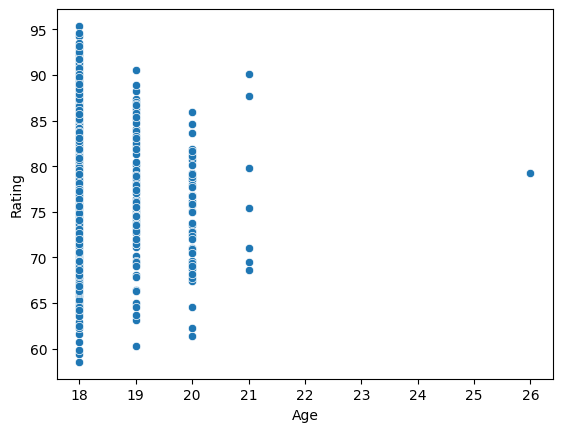

In [16]:
sns.scatterplot(x='Age', y='Rating', data=merged_df)

These plots show that the features, age, round, and overall pick have very slight correlations with the ratings. Therfore it is these features we will use for further analysis.

# Number of Players from each Amateur Team:

USA U-18 Development teams (both) and London Knights have the highest number. However, this does not imply they are the best to select from, as seen below.

# Method

In this analysis of NHL draft picks, machine learning tools play a pivotal role in understanding the factors contributing to the long-term success of players. The primary tool of choice is the Multiple Regression model, employed to predict player success based on the features overall_pick, age and round. This model makes several key assumptions to function effectively, including the independence of observations, which ideally should stem from independent and identically distributed samples. It doesn't assume linearity, although non-linear features must be explicitly made beforehand. Assumptions related to multicollinearity, homoscedasticity, and the normality of residuals should be considered and, when necessary, addressed during data preparation.

The pitfalls of this method are of course choosing which features to use, and at what power/shape. Multiple regression requires choosing features as well as whether to include them as linear, quadratic, etc. This makes it difficult to be confident that the model is the best it could possibly be. However, this can be overcome with time, trying the model multiple times with different combinations of features and shapes of each feature, checking that the assumptions are met each time.


In a broader sense, this means that we are using the data to make a function that takes in the data as an input and producing a rating as an output. This rating is then compared to the actual rating of the players to produce a score. This score is called the $R^2$ value, and although it should not be confused with accuracy, it lies on the same scale (0-1, with closer to 1 being better). This is an applicable model because we are trying to predict a numerical value based on our data. This numerical value of rating is directly applicable to whether you should draft a player, our goal for the analysis.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [19]:
def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_true - y_pred) ** 2)

def show_fit(x, y, slope, intercept, xlabel, ylabel, title):
    plt.figure()
    
    # transform the input data into numpy arrays and flatten them for easier processing
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    
    # plot the actual data
    plt.scatter(x, y, label='data')
    
    # compute linear predictions 
    # x is a numpy array so each element gets multiplied by slope and intercept is added
    y_pred = slope * x + intercept
    
    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='linear fit')
    
    
    plt.legend()
    plt.suptitle(title, fontsize = 15, y=1.02)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # print the mean squared error
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    plt.title(f'y_hat = {slope:.2f} * x + {intercept:.2f}, MSE = {mse:.3f}, R2 = {r2_score(y, y_pred):.2f}')

In [20]:
#check the features independently
x_features = ['Overall', 'Age', 'Round']
for feat in x_features:

    X = merged_df[[feat]]

    for col in X.columns:
        X[col] = X[col] / X[col].std()

    X = np.array(X)
    y = np.array(merged_df['Rating'])

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=12)

    model = LinearRegression()

    model.fit(Xtrain, ytrain)

    ypred = model.predict(Xtest)

    mse = get_mse(ytest, ypred)

    r2 = r2_score(ytest, ypred)

    print("Feature:", feat)
    print("R2:", r2)
    print("MSE:", mse)

Feature: Overall
R2: 0.09306852542318556
MSE: 43.92009126671521
Feature: Age
R2: -0.011825390269950997
MSE: 48.999802887392335
Feature: Round
R2: 0.08288564572529
MSE: 44.41321893757726


In [21]:
#get the numpy arrays of X and y
X = merged_df[['Overall', 'Age', 'Round']]

for col in X.columns:
    X[col] = X[col] / X[col].std()

X = np.array(X)
y = np.array(merged_df['Rating'])

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=12)

model = LinearRegression()

model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

mse = get_mse(ytest, ypred)

r2 = r2_score(ytest, ypred)

print("R2:", r2)
print("MSE:", mse)


R2: 0.102114634568917
MSE: 43.48201413473059


In [22]:
#check different permutations of features
X = merged_df[['Overall', 'Age']]

for col in X.columns:
    X[col] = X[col] / X[col].std()

X = np.array(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=12)

model = LinearRegression()

model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

mse = get_mse(ytest, ypred)

r2 = r2_score(ytest, ypred)

print("R2:", r2)
print("MSE:", mse)

R2: 0.09612561691825228
MSE: 43.77204508986741


In [23]:
X = merged_df[['Round', 'Overall']]

for col in X.columns:
    X[col] = X[col] / X[col].std()

X = np.array(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=12)

model = LinearRegression()

model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

mse = get_mse(ytest, ypred)

r2 = r2_score(ytest, ypred)

print("R2:", r2)
print("MSE:", mse)

R2: 0.10041257898155787
MSE: 43.56443980726855


In [24]:
#check different permutations of features
X = merged_df[['Round', 'Age']]

for col in X.columns:
    X[col] = X[col] / X[col].std()

X = np.array(X)
y = np.array(merged_df['Rating'])

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=12)

model = LinearRegression()

model.fit(Xtrain, ytrain)

ypred = model.predict(Xtest)

mse = get_mse(ytest, ypred)

r2 = r2_score(ytest, ypred)

print("R2:", r2)
print("MSE:", mse)

R2: 0.08468249220688762
MSE: 44.32620281378371


In [26]:
#Attempt to group by round and see if that improves the model

rounds = merged_df.groupby('Round')

for round, data in rounds:
    X = data[['Overall']]

    for col in X.columns:
        X[col] = X[col] / X[col].std()

    X = np.array(X)
    y = np.array(data['Rating'])

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=12)

    model = LinearRegression()

    model.fit(Xtrain, ytrain)

    ypred = model.predict(Xtest)

    mse = get_mse(ytest, ypred)

    r2 = r2_score(ytest, ypred)

    print("\nRound:", round)
    print("R2:", r2)
    print("MSE:", mse)


Round: 1
R2: 0.2179445194031382
MSE: 42.23486789007903

Round: 2
R2: 0.0270645525654839
MSE: 41.79701341245078

Round: 3
R2: -0.22265023607618817
MSE: 63.106838493940764

Round: 4
R2: -0.04561947589999393
MSE: 11.38313175370427

Round: 5
R2: -0.039001358092424665
MSE: 72.4115747764994

Round: 6
R2: -0.40863646984793967
MSE: 38.286341350208424

Round: 7
R2: -0.320745290330154
MSE: 73.18345700521189

Round: 8
R2: nan
MSE: 4.0172553692049595

Round: 9
R2: nan
MSE: 1.516138261643133


/Users/aneelkahlon/.pyenv/versions/3.11.4/envs/DS3000/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/aneelkahlon/.pyenv/versions/3.11.4/envs/DS3000/lib/python3.11/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [41]:
#see if splitting by position improves the model
splits = merged_df[(merged_df['Pos'].isin(['C', 'D', 'LW', 'RW']))].groupby('Pos')

for pos, data in splits:
    X = data[['Overall', 'Round', 'Age']]

    for col in X.columns:
        X[col] = X[col] / X[col].std()

    X = np.array(X)
    y = np.array(data['Rating'])

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=12)

    model = LinearRegression()

    model.fit(Xtrain, ytrain)

    ypred = model.predict(Xtest)

    mse = get_mse(ytest, ypred)

    r2 = r2_score(ytest, ypred)

    print("\nPosition:", pos)
    print("R2:", r2)
    print("MSE:", mse)


Position: C
R2: 0.2551982619067936
MSE: 52.57230766009367

Position: D
R2: 0.08329402575918043
MSE: 16.631443966766877

Position: LW
R2: -0.03339570876278186
MSE: 53.920829510712245

Position: RW
R2: -0.04300985675306257
MSE: 90.94838550162595


# Final Models

## Single Feature Models:

### Overall Pick:

R2: 0.0951893180376453
MSE: 44.691319202264715


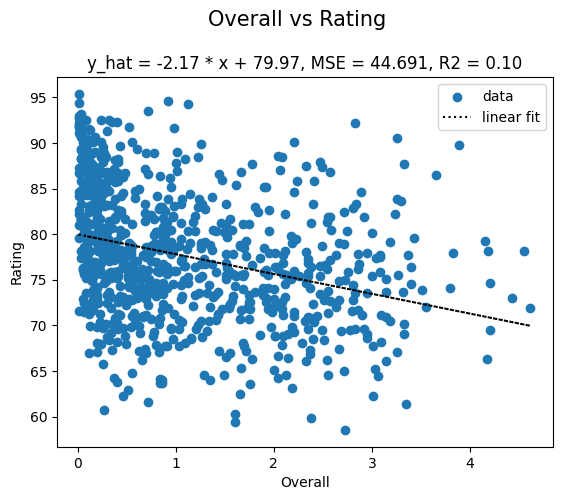

In [42]:
#Model of just overall
X = merged_df[['Overall']]

for col in X.columns:
    X[col] = X[col] / X[col].std()

X = np.array(X)
y = np.array(merged_df['Rating'])

model = LinearRegression()

model.fit(X, y)

slope = model.coef_[0]

# get the intercept
intercept = model.intercept_

y_pred = model.predict(X)

mse = get_mse(y, model.predict(X))
r2 = r2_score(y, model.predict(X))

error = y - y_pred

show_fit(X, y, slope, intercept, 'Overall', 'Rating', 'Overall vs Rating')

print("R2:", r2)
print("MSE:", mse)


Text(0, 0.5, 'residuals')

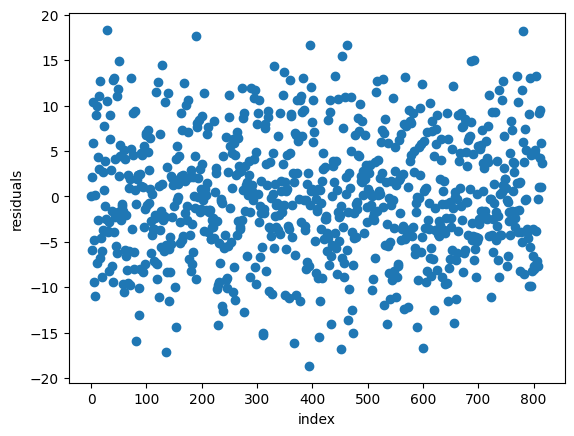

In [28]:
plt.scatter(x = range(len(y)), y = error)
plt.xlabel('index')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

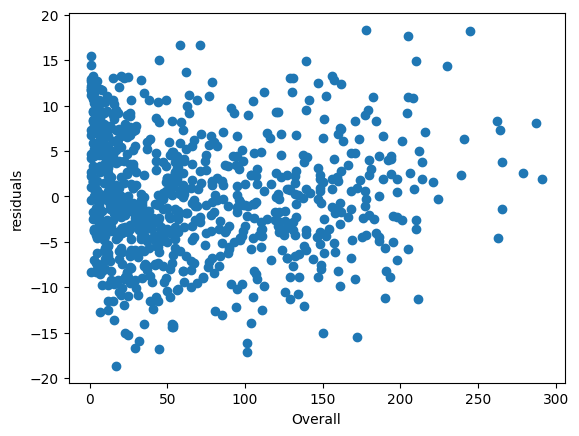

In [29]:
plt.scatter(x = merged_df['Overall'], y = error)
plt.xlabel('Overall')
plt.ylabel('residuals')

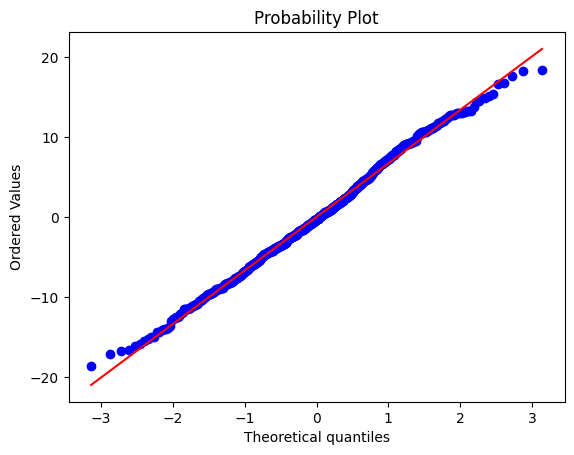

In [30]:
stats.probplot(error, dist="norm", plot=py)
py.show()

### Round:

R2: 0.08645139548010672
MSE: 45.12291146125163


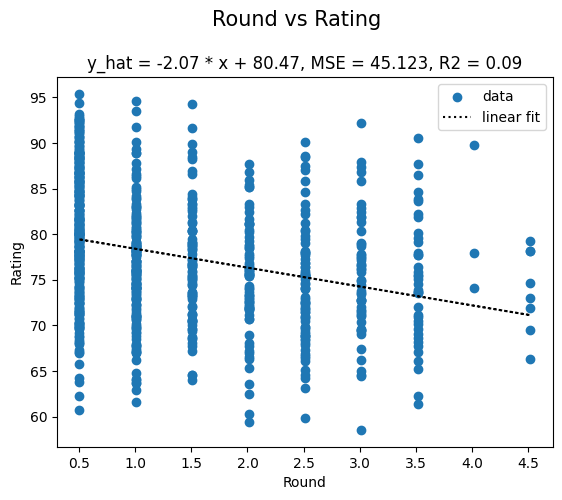

In [31]:
#Model of just overall
X = merged_df[['Round']]

for col in X.columns:
    X[col] = X[col] / X[col].std()

X = np.array(X)
y = np.array(merged_df['Rating'])

model = LinearRegression()

model.fit(X, y)

slope = model.coef_[0]

# get the intercept
intercept = model.intercept_

y_pred = model.predict(X)

error = y - y_pred

mse = get_mse(y, model.predict(X))
r2 = r2_score(y, model.predict(X))

show_fit(X, y, slope, intercept, 'Round', 'Rating', 'Round vs Rating')

print("R2:", r2)
print("MSE:", mse)

Text(0, 0.5, 'residuals')

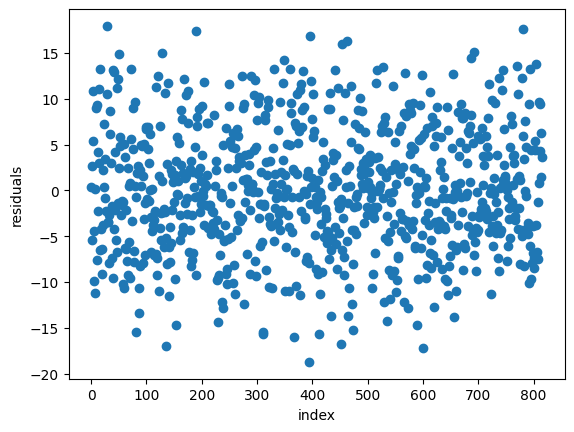

In [32]:
plt.scatter(x = range(len(y)), y = error)
plt.xlabel('index')
plt.ylabel('residuals')

Text(0, 0.5, 'residuals')

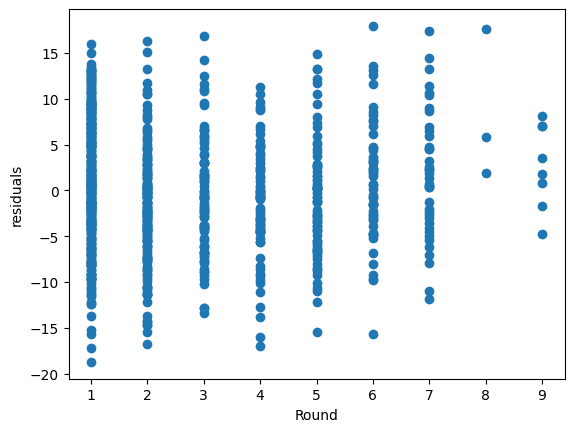

In [33]:
plt.scatter(x = merged_df['Round'], y = error)
plt.xlabel('Round')
plt.ylabel('residuals')

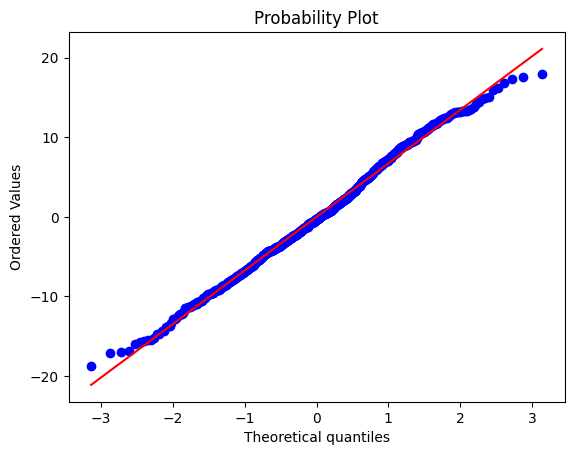

In [34]:
stats.probplot(error, dist="norm", plot=py)
py.show()

## Multi-Feature Models:

### Overall Pick + Age + Round:

R2: 0.10213598981702743
MSE: 44.34820220323414


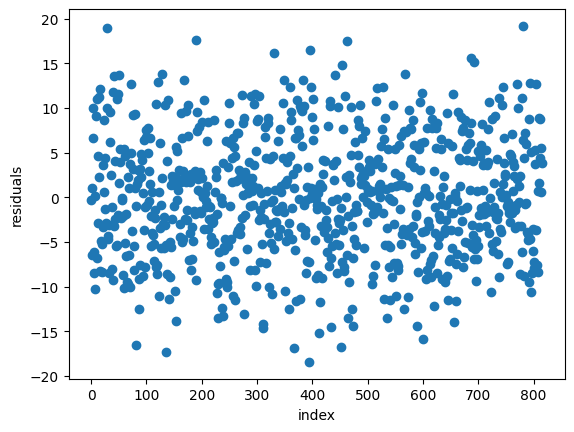

In [35]:
X = merged_df[['Overall', 'Round', 'Age']]

for col in X.columns:
    X[col] = X[col] / X[col].std()

X = np.array(X)
y = np.array(merged_df['Rating'])

model = LinearRegression()

model.fit(X, y)

slope = model.coef_[0]

# get the intercept
intercept = model.intercept_

mse = get_mse(y, model.predict(X))
R2 = r2_score(y, model.predict(X))
y_pred = model.predict(X)

error = y - y_pred

plt.scatter(x = range(len(y)), y = error)
plt.xlabel('index')
plt.ylabel('residuals')
print("R2:", R2)
print("MSE:", mse)

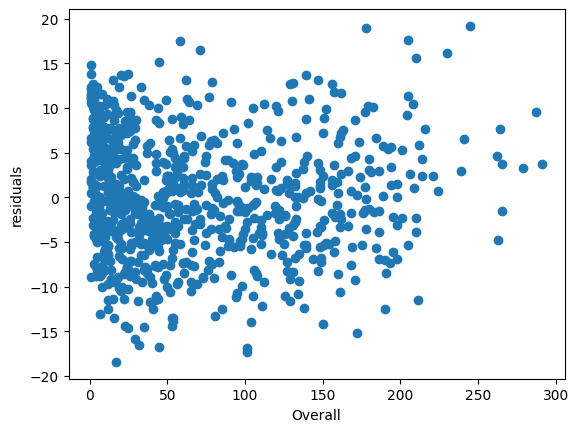

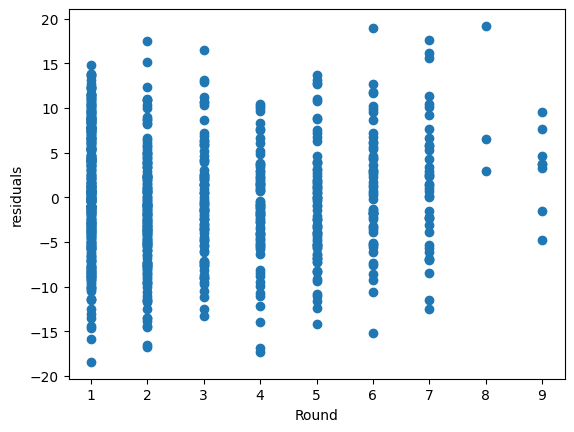

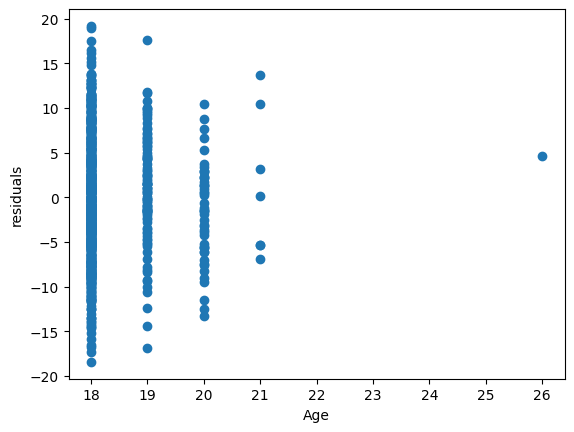

In [36]:
for feat in ['Overall', 'Round', 'Age']:
    plt.scatter(x = merged_df[feat], y = error)
    plt.xlabel(feat)
    plt.ylabel('residuals')
    plt.show()

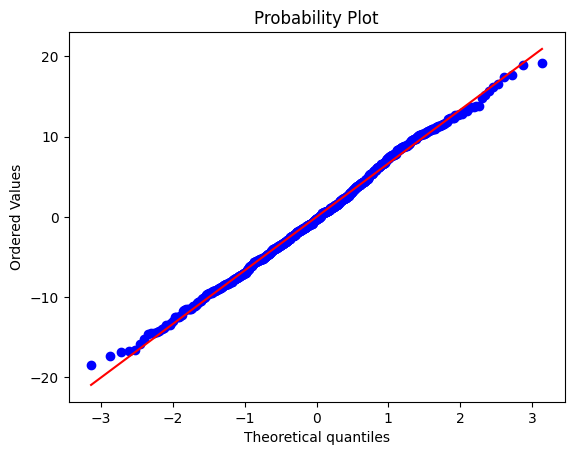

In [37]:
stats.probplot(error, dist="norm", plot=py)
py.show()

## Model only Trained on Centers

R2: 0.22053741108275693
MSE: 48.649494603439905


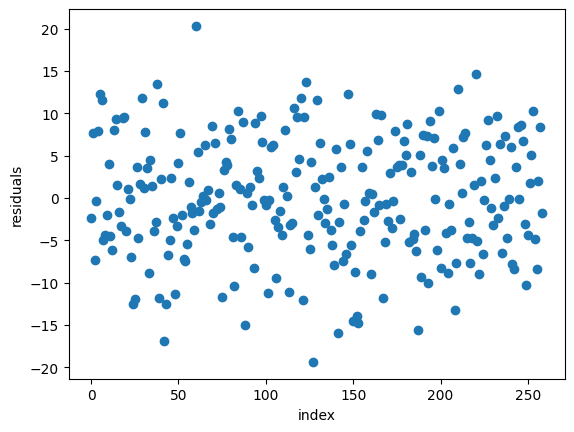

In [38]:
data = merged_df[(merged_df['Pos'].isin(['C']))]

#check different permutations of features
X = data[['Overall', 'Round', 'Age']]

for col in X.columns:
    X[col] = X[col] / X[col].std()

X = np.array(X)
y = np.array(data['Rating'])

model = LinearRegression()

model.fit(X, y)

slope = model.coef_[0]

# get the intercept
intercept = model.intercept_

mse = get_mse(y, model.predict(X))
r2 = r2_score(y, model.predict(X))
y_pred = model.predict(X)

error = y - y_pred

plt.scatter(x = range(len(y)), y = error)
plt.xlabel('index')
plt.ylabel('residuals')
print("R2:", r2)
print("MSE:", mse)

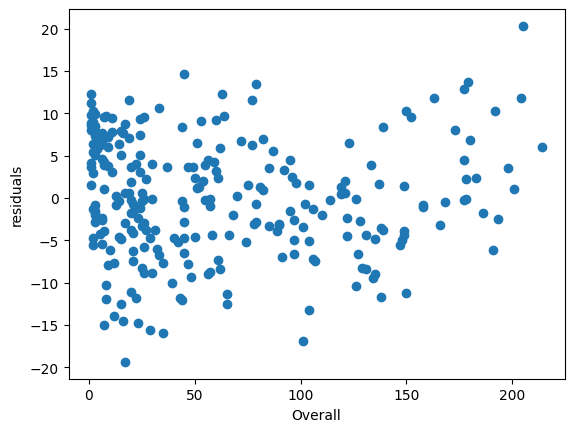

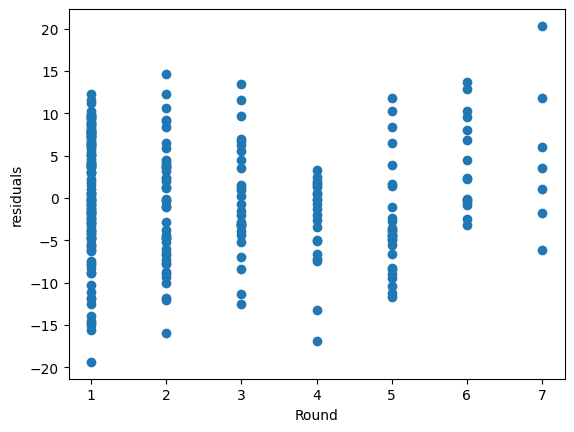

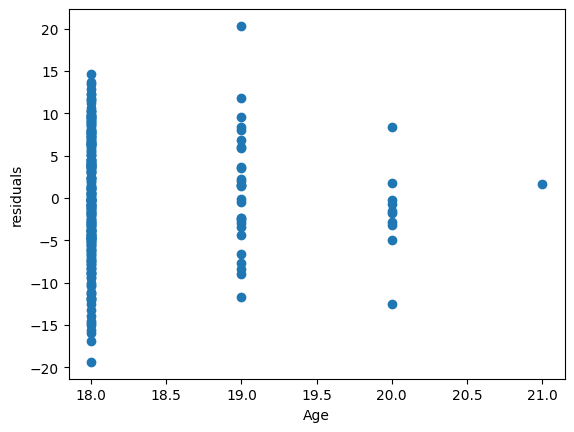

In [39]:
for feat in ['Overall', 'Round', 'Age']:
    plt.scatter(x = data[feat], y = error)
    plt.xlabel(feat)
    plt.ylabel('residuals')
    plt.show()

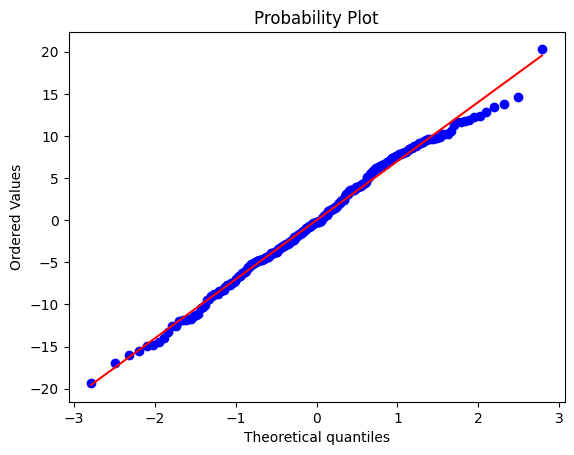

In [40]:
stats.probplot(error, dist="norm", plot=py)
py.show()